In [122]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
from d2l import torch as d2l

### Load Dataset

In [123]:
# ToTensor()会转到[0,1]
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = torchvision.datasets.MNIST("mnist_data", train=True, download=False,transform=trans)

In [124]:
batchsize = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)

In [125]:
X,y = dataloader.__iter__().__next__()
display(X.shape,y.shape)

torch.Size([32, 1, 28, 28])

torch.Size([32])

Text(0.5, 1.0, 'tensor(2)')

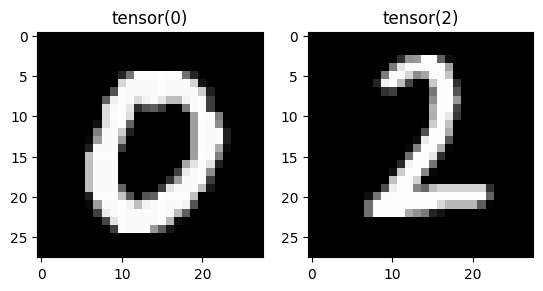

In [126]:
# 纯黑色是0 纯白色是1
fig,ax = d2l.plt.subplots(1,2)
ax[0].imshow(X[0][0].numpy(),cmap='gray')
ax[0].set_title(y[0])
ax[1].imshow(X[1][0].numpy(),cmap='gray')
ax[1].set_title(y[1])

### Net

In [127]:
image_size = (1,28,28)
latent_dim = 96
device = torch.device('cuda')

In [128]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            
            nn.Linear(latent_dim, 128),
            # BN_1d in MLP: (batch,features)
            # BN_2d in CNN: (batch,h,w)
            torch.nn.BatchNorm1d(128),
            torch.nn.GELU(),

            nn.Linear(128, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.GELU(),
            
            nn.Linear(256, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.GELU(),
            
            nn.Linear(512, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.GELU(),
            # 输出维度和正常照片一样
            # np.prod(image_size) = 28*28
            nn.Linear(1024, np.prod(image_size, dtype=np.int32)),
            #  nn.Tanh()
            nn.Sigmoid(),
        )

    def forward(self, z):
        # shape of z: [batchsize, latent_dim]

        output = self.model(z)
        image = output.reshape(z.shape[0], *image_size)

        return image

In [129]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(np.prod(image_size, dtype=np.int32), 512),
            torch.nn.GELU(),
            nn.Linear(512, 256),
            torch.nn.GELU(),
            nn.Linear(256, 128),
            torch.nn.GELU(),
            nn.Linear(128, 64),
            torch.nn.GELU(),
            nn.Linear(64, 32),
            torch.nn.GELU(),
            nn.Linear(32, 1),
            # (0,1)
            nn.Sigmoid(),
        )

    def forward(self, image):
        # shape of image: [batchsize, 1, 28, 28]
        # prob shape: (batch_size,1)
        prob = self.model(image.reshape(image.shape[0], -1))

        return prob

### LOSS

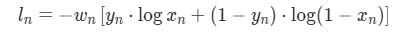

训练Generator：随机生成Image, 丢给discriminator，得到loss <br>
训练Discriminator：从生成数据和真实数据取样，丢给discriminator，得到loss

In [130]:
label_fake = torch.ones((batchsize,1),dtype=torch.float32).to(device)
label_true = torch.zeros((batchsize,1),dtype=torch.float32).to(device)

In [131]:
class G_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCELoss(reduction='mean')
    def forward(self,pred,target,true_img,g_img):
        # pred/targe shape: [batchsize,1]
        diff = torch.abs(true_img-g_img).mean()
        loss = diff*0.05 + self.loss(pred,target)
        return loss

### 训练

In [132]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0003, betas=(0.4, 0.8), weight_decay=0.0001)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0003, betas=(0.4, 0.8), weight_decay=0.0001)
D_loss = nn.BCELoss(reduction='none')
G_loss = G_loss()

In [135]:
epochs = 10
for i in range(epochs):
    for X,_ in dataloader:
        X = X.to(device)
        # 更新Generator
        z = torch.randn(batchsize,latent_dim).to(device)
        generator.train()
        g_optimizer.zero_grad()
        # g_img.shape: [batchsize,dims,h,w]
        g_img = generator(z)
        prob = discriminator(g_img)
        g_loss = G_loss(prob,label_fake,X,g_img)
        g_loss.backward()
        g_optimizer.step()

        # 更新Discriminator
        discriminator.train()
        d_optimizer.zero_grad()
        loss_true = D_loss(discriminator(X),label_true)
        loss_fake = D_loss(discriminator(g_img.detach()),label_fake)
        d_loss = loss_true + loss_fake
        d_loss.mean().backward()
        d_optimizer.step()

    # if i+1%50 == 0 or i == 5:
    print(f"step:{i},  g_loss:{g_loss.item()}, d_loss:{d_loss.mean()}, real_loss:{loss_true.mean()}, fake_loss:{loss_fake.mean()}")

KeyboardInterrupt: 

In [ ]:
generator.eval()
z = torch.randn(18,latent_dim).to(device)
pred_img = generator(z).detach().to(torch.device('cpu'))

In [ ]:
d2l.show_images(pred_img.reshape(18,28,28),2,9)